In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os
from opto_untils import makedirs
from plot_untils import shiftedColorMap
# load pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# load kmeans
from sklearn.cluster import KMeans
# load gmm
from sklearn.mixture import GaussianMixture
# load tsne
from sklearn.manifold import TSNE

from scipy.stats import zscore

from sklearn.cluster import KMeans

from sklearn.decomposition import FastICA
import warnings

colors = ["blue", "white", "red"]
b_w_r_cmap = LinearSegmentedColormap.from_list("b_w_r", colors)

In [4]:
# fs = 50000
# fc2 = 6000

# aps = pd.read_csv("/root/capsule/data/meanAPs.csv")
# aps.drop('Unnamed: 0', axis=1, inplace=True)
# aps = aps.values

# aps_tag = pd.read_csv("/root/capsule/data/meanAPsLCNEretroCortex.csv")
# aps_tag.drop('Unnamed: 0', axis=1, inplace=True)
# aps_tag = aps_tag.values

# all_aps = np.vstack((aps, aps_tag))
# tag_ind = np.vstack((np.zeros((np.shape(aps)[0],1)), np.ones((np.shape(aps_tag)[0],1))))

In [3]:
fs = 50000
fc2 = 6000

aps = pd.read_csv("/root/capsule/data/LCapShapes.csv")
aps.drop('Unnamed: 0', axis=1, inplace=True)
aps = aps.values

all_aps = aps
tag_ind = np.hstack((np.zeros(63), np.ones(20), 2*np.ones(11), 3*np.ones(43), 4*np.ones(6))).reshape(-1, 1)
tag_id = {'0': 'unknown', '1': 'ctx', '2': 'cb', '3': 'sp', '4': 'th'}

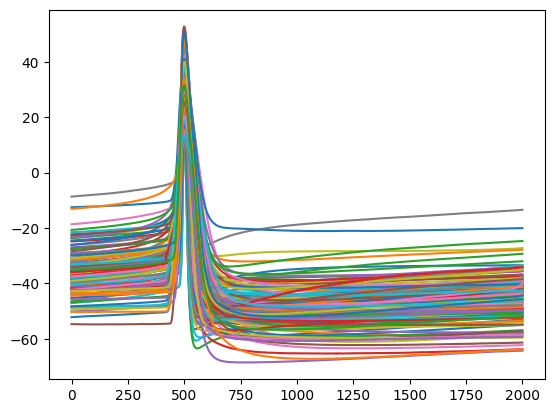

In [4]:
plt.plot(aps.T);

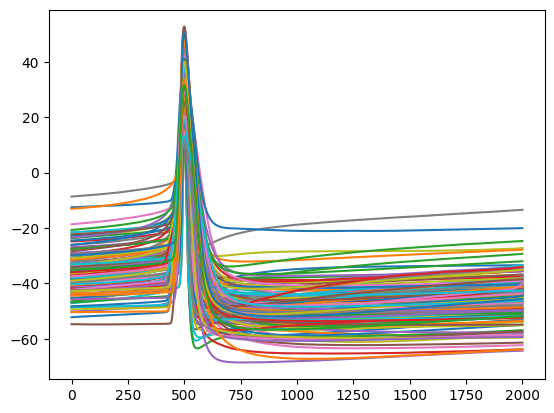

In [5]:
# filtering

# Butterworth filter design
b2, a2 = butter(2, fc2 / (fs / 2), btype='low')

# Filtering loop
for i in range(all_aps.shape[0]):
    if not np.isnan(all_aps[i, :]).any():
        all_aps[i, :] = filtfilt(b2, a2, all_aps[i, :])

plt.plot(all_aps.T);

# nan_ind
nan_ind = np.isnan(all_aps[:, 0])

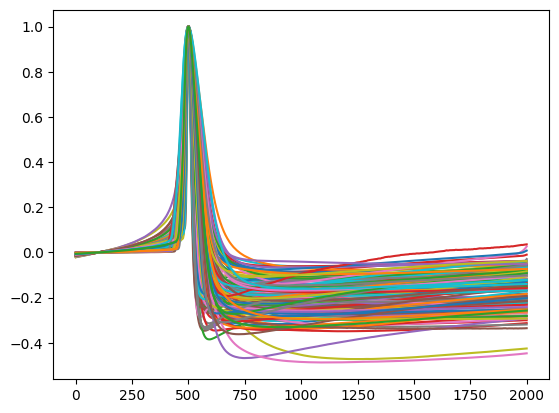

In [6]:
# Step 0: raw version
baseline = np.mean(all_aps[:, :200], axis=1)
meanSpike_bl = all_aps - baseline[:, np.newaxis]
peak = meanSpike_bl[:, 500]
meanSpike_nl = meanSpike_bl / peak[:, np.newaxis]
plt.plot(meanSpike_nl.T);

In [7]:
# Step 1: 1D
meanSpike_1D = np.diff(all_aps, axis=1)
baseline_1D = np.mean(meanSpike_1D[:, :200], axis=1)
peak1D = np.zeros(meanSpike_1D.shape[0])
peakInd = np.zeros(meanSpike_1D.shape[0], dtype=int)
meanSpike_1D_realign = np.zeros((meanSpike_1D.shape[0], 400))
meanSpike_1D_bl = meanSpike_1D.copy() - baseline_1D[:, np.newaxis]

for i in range(meanSpike_1D_bl.shape[0]):
    peak1D[i], peakInd[i] = np.max(meanSpike_1D_bl[i, :]), np.argmax(meanSpike_1D_bl[i, :])
    if not np.isnan(peak1D[i]):
        meanSpike_1D_realign[i, :] = meanSpike_1D_bl[i, (peakInd[i] - 120):(peakInd[i] + 280)].copy()

meanSpike_1D_nl = meanSpike_1D_realign.copy() / peak1D[:, np.newaxis]


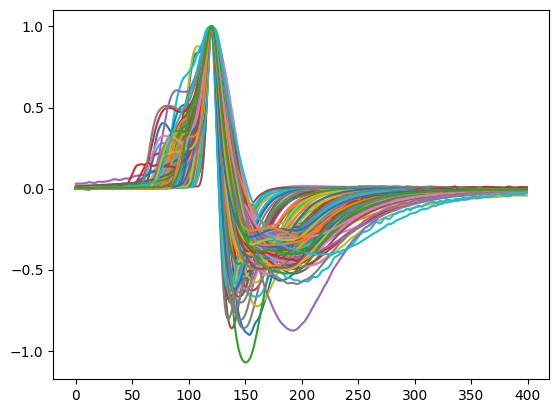

In [8]:
plt.plot(meanSpike_1D_nl.T);

In [9]:

# Step 2: Z-score normalization
meanSpike_1D_nl_ZS = np.full(meanSpike_1D_nl.shape, np.nan)
for i in range(meanSpike_1D_nl.shape[1]):
    tmp = meanSpike_1D_nl[:, i].copy()
    if not np.isnan(tmp).all():
        tmp[~np.isnan(tmp)] = zscore(tmp[~np.isnan(tmp)])
    meanSpike_1D_nl_ZS[:, i] = tmp
 
meanSpike_nl_ZS = np.full(meanSpike_nl.shape, np.nan)
for i in range(meanSpike_nl_ZS.shape[1]):
    tmp = meanSpike_nl[:, i].copy()
    if not np.isnan(tmp).all():
        tmp[~np.isnan(tmp)] = zscore(tmp[~np.isnan(tmp)])
    meanSpike_nl_ZS[:, i] = tmp


In [10]:
# calculate features
# 1. ahp
ahp = np.min(meanSpike_1D_nl[:, 120:], axis=1)
# 2. phdis
ptdis = np.argmin(meanSpike_1D_nl[:, 120:], axis=1)

In [24]:
colors = [[0.7,0.7,0.7],[0, 0, 0]]
# preparation
X = meanSpike_nl[~nan_ind, :].copy()
X = X[:, np.r_[500 - 120:500, 501:500 + 280]]

# X = meanSpike_1D_nl[~nan_ind, :].copy()
# X = X[:, np.r_[:120, 121:np.shape(X)[1]]]

# X = meanSpike_nl[~nan_ind, :].copy()
# X = X[:, np.r_[500 - 120:500, 501:500 + 280]]

# Y = meanSpike_1D_nl[~nan_ind, :].copy()
# Y = Y[:, np.r_[:120, 121:np.shape(Y)[1]]]

# X = np.vstack([X, Y])

# Step 3: PCA
pca = PCA()
score = pca.fit_transform(X)

# # Step 4: RICA (using ICA for translation)
# ica = FastICA(n_components=5)
# allWFs = meanSpike_nl[:, (500 - 120):(500 + 280)]
# score = ica.fit_transform(allWFs)


In [12]:
for idx, region in tag_id.items():
    print(f'{idx}: {region}')

0: unknown
1: ctx
2: cb
3: sp
4: th


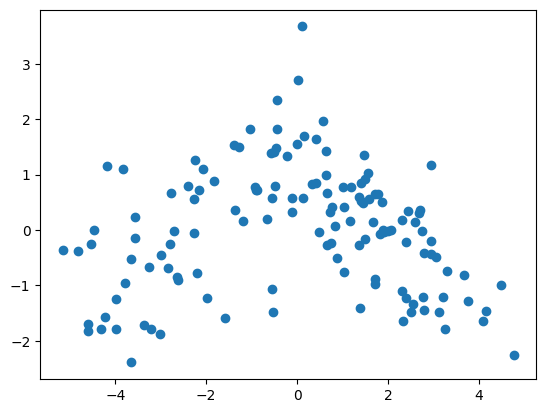

1: ctx
Ploting in 0
2: cb
Ploting in 1
3: sp
Ploting in 2
4: th
Ploting in 3


/tmp/ipykernel_7038/1791577223.py:51: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y[indRaw == group_ind, 0], y[indRaw == group_ind, 1], c = colors[group_ind], label = f'cluster {group_ind}')
/tmp/ipykernel_7038/1791577223.py:59: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(score[indRaw == group_ind, 0], score[indRaw == group_ind, 1], c = colors[group_ind], label = f'cluster {group_ind}')


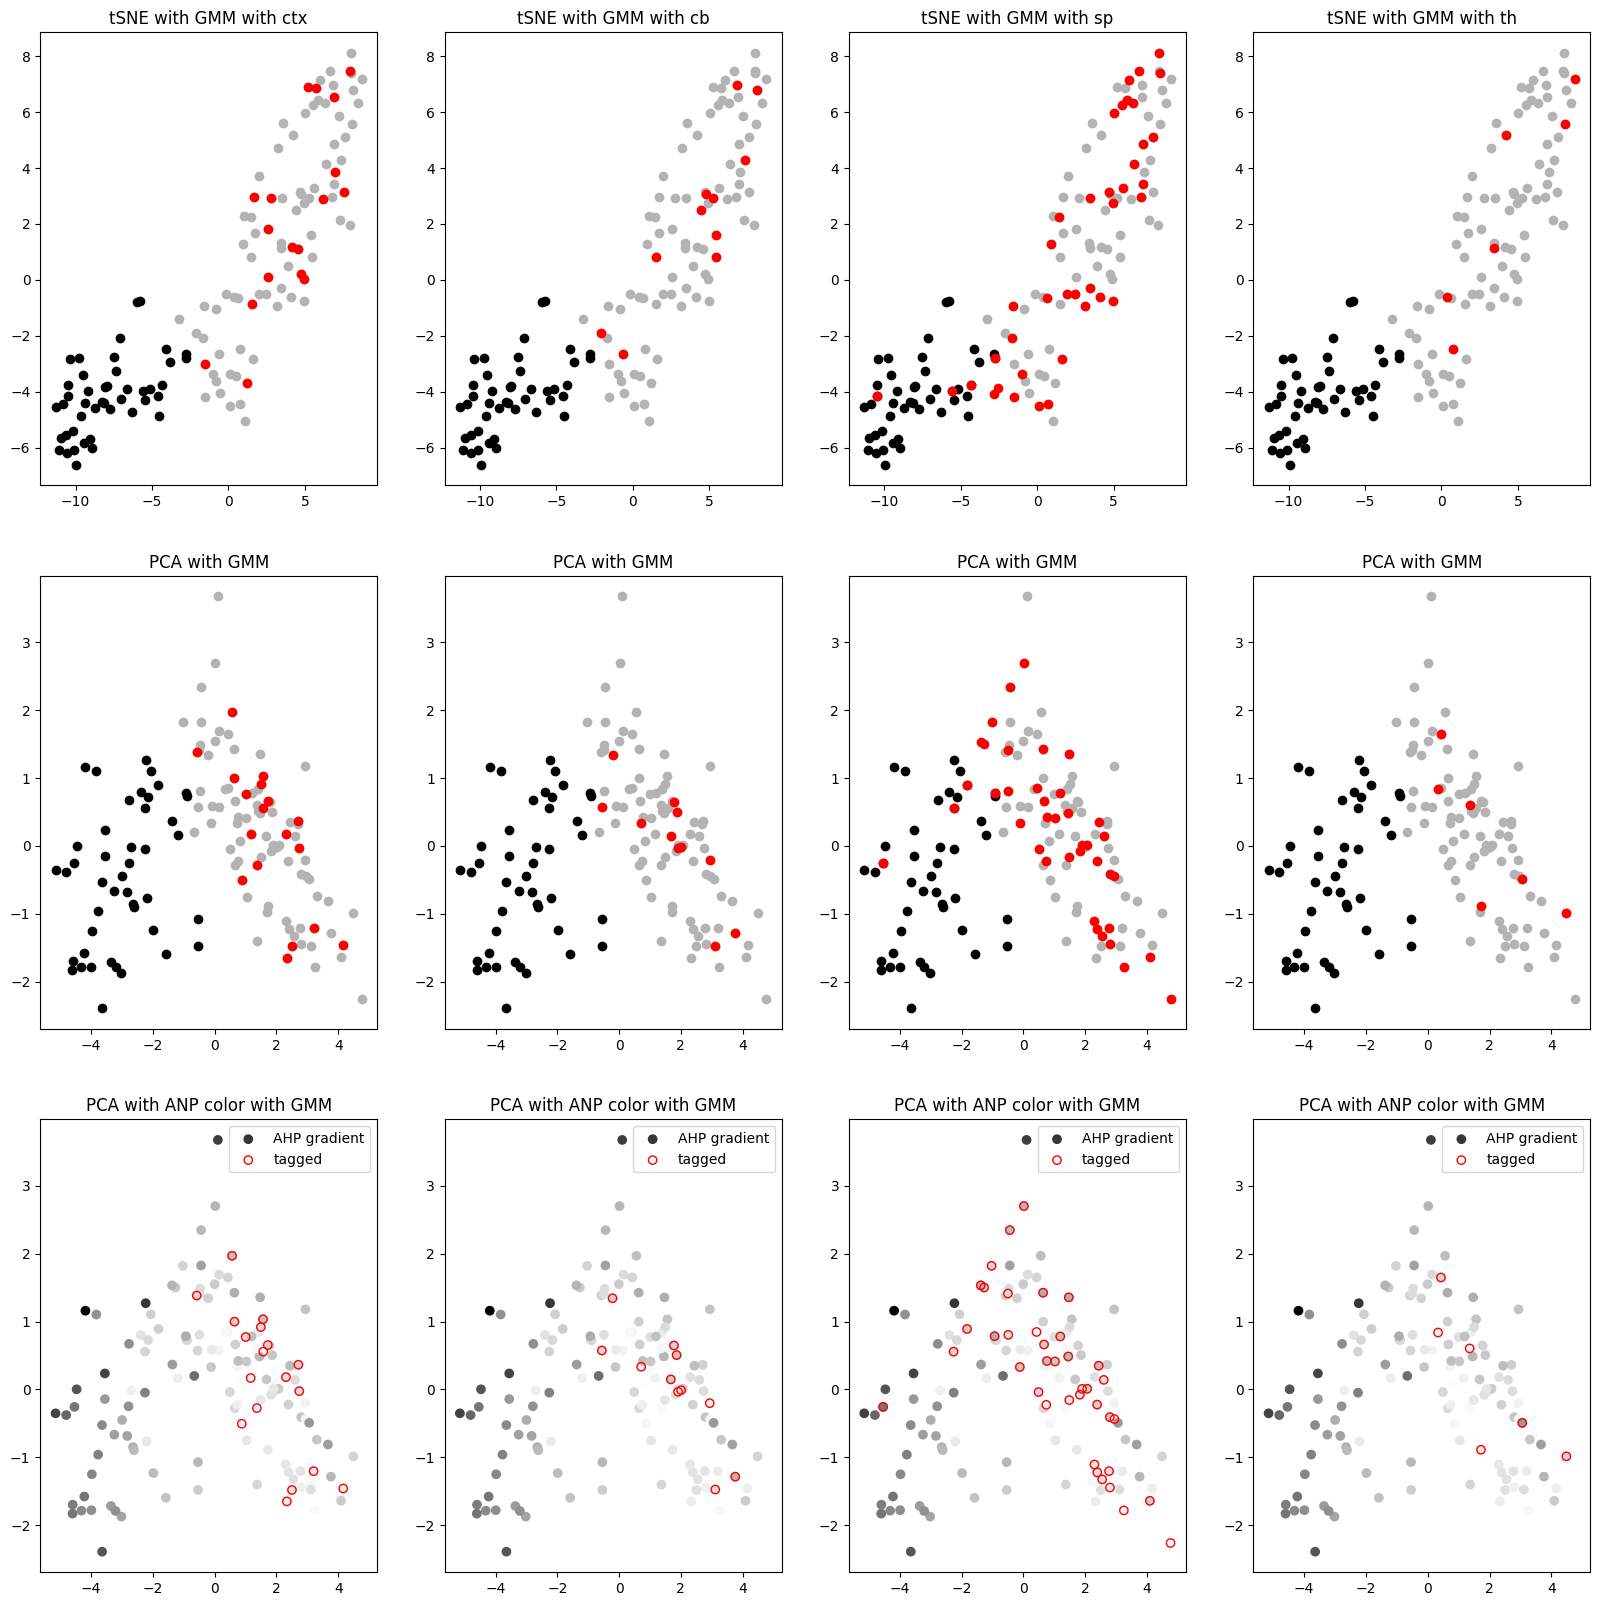

<Figure size 640x480 with 0 Axes>

In [26]:
colors = [[0,0,0],[0.7, 0.7, 0.7]]
clustering = 'GMM'
# Step 5: Scatter plot
plt.figure()
plt.scatter(score[:, 0], score[:, 1])
plt.show()

# Step 6: Gaussian Mixture Model (GMM)
scoreTmp = score[~np.isnan(score).any(axis=1), :]
gmm = GaussianMixture(n_components=2, init_params='kmeans')
gmm.fit(score[:, :5])
expectations = gmm.predict_proba(score[:, :5])
theta = gmm.means_

# Step 7: K-means clustering
numCat = 2
indAll = []
dis = []

for a in range(10):
    kmeans = KMeans(n_clusters=numCat)
    ind = kmeans.fit_predict(score[:, :5])
    indAll.append(ind)
    dis.append(kmeans.inertia_)

optiInds = np.argmin(dis)
indRaw = indAll[optiInds]

# Step 8: Confidence thresholding
if clustering == 'GMM':
    confThresh = 0.8
    confG = np.max(expectations, axis=1)
    indG = np.argmax(expectations, axis=1)
    indG[confG < confThresh] = 5
    indRaw = np.full(score.shape[0], 5)
    indRaw = indG

# Step 9: t-SNE visualization
tsne = TSNE(n_components=2)
y = tsne.fit_transform(score[:, :5])
# visualization by tags
fig = plt.figure(figsize=(20, 20))
axes = fig.subplots(3, len(tag_id.keys())-1)
tag_ind_nan = np.squeeze(tag_ind[~nan_ind])
for idx, region in tag_id.items():
    if int(idx) != 0:
        print(f'{idx}: {region}')
        print(f'Ploting in {int(idx)-1}')
        ax = axes[0, int(idx)-1]
        for group_ind in range(numCat):
            ax.scatter(y[indRaw == group_ind, 0], y[indRaw == group_ind, 1], c = colors[group_ind], label = f'cluster {group_ind}')
        ax.scatter(y[tag_ind_nan == int(idx), 0], y[tag_ind_nan == int(idx), 1], c = 'r')
        ax.set_title(f'tSNE with {clustering} with {region}')


        # Step 10: GMM or kmeans plot with score
        ax = axes[1, int(idx)-1]
        for group_ind in range(numCat):
            ax.scatter(score[indRaw == group_ind, 0], score[indRaw == group_ind, 1], c = colors[group_ind], label = f'cluster {group_ind}')

        ax.scatter(score[tag_ind_nan == int(idx), 0], score[tag_ind_nan == int(idx), 1], c = 'r')
        ax.set_title(f'PCA with {clustering}')

        # Step 11: feature and tagging
        ax = axes[2, int(idx)-1]
        ax.scatter(score[:,0], score[:, 1], c = ahp[~nan_ind], cmap = 'grey', label = f'AHP gradient')
        ax.set_title(f'PCA with ANP color with {clustering}')

        ax.scatter(score[tag_ind_nan == int(idx), 0], score[tag_ind_nan == int(idx), 1], label = 'tagged', edgecolors = 'r', facecolors = 'none')
        ax.legend()

plt.show()
plt.savefig((os.path.join("/root/capsule/scratch/", "feature_plot_with_tag.pdf")), format='pdf')



/tmp/ipykernel_571/1656890806.py:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(group_ind*np.ones(np.sum(indRaw == group_ind)) + np.random.uniform(-0.1, 0.1, np.sum(indRaw == group_ind)), ahp[~nan_ind][indRaw == group_ind], c = colors[group_ind])


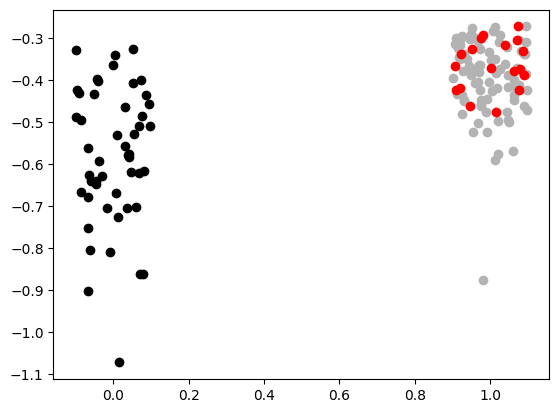

In [19]:
for group_ind in range(numCat):
    plt.scatter(group_ind*np.ones(np.sum(indRaw == group_ind)) + np.random.uniform(-0.1, 0.1, np.sum(indRaw == group_ind)), ahp[~nan_ind][indRaw == group_ind], c = colors[group_ind])

plt.scatter(indRaw[tag_ind_nan == 1]+np.random.uniform(-0.1, 0.1, np.sum(tag_ind_nan == 1)), ahp[~nan_ind][tag_ind_nan == 1], c = 'r')
plt.savefig((os.path.join("/root/capsule/scratch/", "aph_with_tag.pdf")), format='pdf')

In [21]:
ahp[indRaw == group_ind]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 74 but corresponding boolean dimension is 71

In [2]:
plt.scatter(score[:,0], ahp[~nan_ind], c = ahp[~nan_ind], cmap = 'bwr')

NameError: name 'plt' is not defined

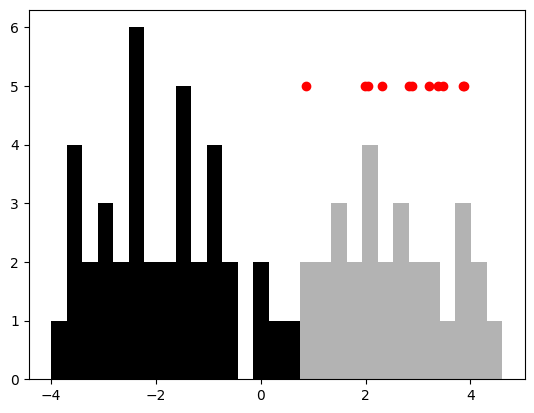

In [19]:
bins = np.linspace(np.min(score[:,0])-0.001, np.max(score[:,0])+0.001, 30)
for group_ind in range(numCat):
    plt.hist(score[indRaw == group_ind, 0], bins=bins, color = colors[group_ind])

plt.scatter(score[tag_ind_nan==1, 0], 5*np.ones(np.sum(tag_ind_nan==1)), c = 'r')
plt.savefig((os.path.join("/root/capsule/scratch/", "PC1_hist_with_tag.pdf")), format='pdf')

In [155]:
score[tag_ind_nan, 0]

IndexError: arrays used as indices must be of integer (or boolean) type

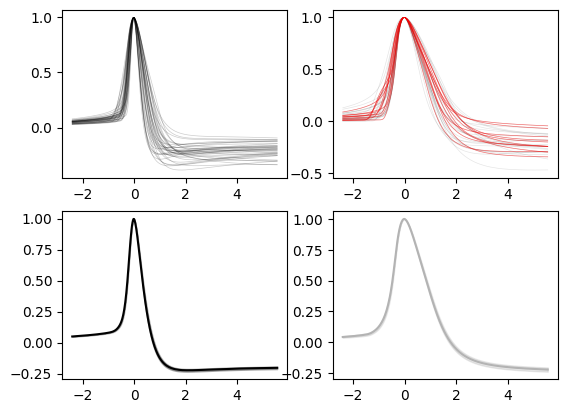

In [128]:

# Step 11: Filled plot
time = np.arange(-120, -120+np.shape(X)[1]) / 50000 * 1000

def plotFilled(time, data, color):
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)/np.sqrt(data.shape[0])
    plt.fill_between(time, mean - std, mean + std, color=color, alpha=0.3)
    plt.plot(time, mean, color=color)

plt.figure()
plt.subplot(2, 2, 1)
plt.plot(time, X[indRaw == 0, :].T, 'k', alpha=0.2, linewidth=0.5)
plt.subplot(2, 2, 2)
plt.plot(time, X[indRaw == 1, :].T, 'k', alpha=0.1, linewidth=0.5)
plt.plot(time, X[tag_ind_nan == 1, :].T, 'r', alpha=0.5, linewidth=0.5)

plt.subplot(2, 2, 3)
plotFilled(time, X[indRaw == 0, :], 'k')
plt.subplot(2, 2, 4)
plotFilled(time, X[indRaw == 1, :], color=[0.7, 0.7, 0.7])
plt.show()


In [ ]:

# Step 12: Plot for type I and II
plt.figure()
typeIInd = np.where(indRaw == 1)[0]
for i, ind in enumerate(typeIInd):
    plt.subplot(6, 8, i + 1)
    plt.plot(time, meanSpike_nl[ind, 500-120:500+280], 'k', linewidth=2)
plt.suptitle('Type I')
plt.show()

# Step 13: Histogram
plt.figure()
pdInd = 1
edges = np.linspace(min(score[:, pdInd]) - 0.001, max(score[:, pdInd]) + 0.001, 20)
plt.hist(score[indRaw == 1, pdInd], bins=edges, color='k', density=True, alpha=0.6)
plt.hist(score[indRaw == 2, pdInd], bins=edges, color=[0.4, 0.4, 0.4], density=True, alpha=0.6)
plt.show()

# Step 14: Subplot of Types I and II
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(time, meanSpike_nl[indRaw == 1, 500-120:500+280].T, 'k')
plt.title('Type I')

plt.subplot(1, 2, 2)
plt.plot(time, meanSpike_nl[indRaw == 2, 500-120:500+280].T, color=[0.7, 0.7, 0.7])
plt.title('Type II')
plt.show()
